In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision import models


from torchsummary import summary
from tqdm.notebook import tqdm
from collections import namedtuple

import time
import random
import os

In [32]:
class PyTorch_CNN(nn.Module):
    def __init__(self):

        super(PyTorch_CNN, self).__init__()
        self.conv3d_1 = nn.Conv3d(1, 16, kernel_size=3, stride=1)
        self.tanh_1 = nn.Tanh()
        self.bn1 = nn.BatchNorm3d(16)
        self.drop_1 = nn.Dropout(0.25)
        self.conv3d_2 = nn.Conv3d(16, 32, kernel_size=2, stride=1)
        self.tanh_2 = nn.Tanh()        
        self.bn2 = nn.BatchNorm3d(32)
        self.drop_2 = nn.Dropout(0.25)
        self.conv3d_3 = nn.Conv3d(32, 64, kernel_size=2, stride=1)
        self.tanh_3 = nn.Tanh()
        self.bn3 = nn.BatchNorm3d(64)
        self.drop_3 = nn.Dropout(0.25)
        self.flat_1 = nn.Flatten()
        self.lin_1 = nn.Linear(64*19*19, 11)
        self.lambda_1 = Lambda(lambda x: x.view(x.size(0), -1))


    def forward(self, x):

        x = self.conv3d_1(x)
        x = self.tanh_1(x)
        x = self.bn1(x)
        x = self.drop_1(x)
        x = self.conv3d_2(x)
        x = self.tanh_2(x)
        x = self.bn2(x)
        x = self.drop_2(x)
        x = self.conv3d_3(x)
        x = self.tanh_3(x)
        x = self.bn3(x)
        x = self.drop_3(x)
        x = self.flat_1(x)
        x = self.lin_1(x)
        y_pred = self.lambda_1(x)
        return y_pred

In [4]:
class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [5]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [6]:
# Generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


In [7]:
# Custom view layer
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


In [8]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    yb = np.squeeze(yb)
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [34]:
# Fit model
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, batches, verbose):
    train_losses = []
    validation_losses = []
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
      
        batch = 1
        
        model.train()

        loss = 0

        # With progress bar
        if verbose == 1:
            for xb, yb in tqdm(train_dl):
                loss_batch(model, loss_func, xb, yb, opt)

        # Without progress bar
        if verbose == 2:
            for xb, yb in train_dl:
                batch_loss, batch_size = loss_batch(model, loss_func, xb, yb, opt)
                loss += batch_loss
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1

        loss=loss/batch

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_losses.append(loss)
        validation_losses.append(val_loss)

        print('loss = {}      val_loss: {}'.format(loss, val_loss))

    return train_losses, validation_losses

In [10]:
def preprocess(x, y):
    return x.view(-1, 1, 5, 23, 23).to(dev), y.to(dev)

In [11]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [12]:
# NRMSE loss function
def nrmse_loss(y_pred, y_true):
    diff = torch.div(y_pred - y_true, torch.max(y_true) - torch.min(y_true) + 1e-6)
    return torch.sqrt(torch.mean(torch.square(diff)))

In [17]:
# Load dataset created from notebook 'Debias_Data_Cosima'
t_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/twenty_training_data.npz', allow_pickle=True)
v_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/twenty_val_data.npz', allow_pickle=True) 

training_data = t_data['arr_0'] # saves the array from t_data file
print(training_data.shape)

val_data = v_data['arr_0'] 
print(val_data.shape)

# This part reorganises the array into input and label arrays, mainly to help it feed into model with correct shapes
# For training data
train_X = []
train_Y = []

for i in range (len(training_data)):
  train_X.append(training_data[i][0])
  train_Y.append(training_data[i][1])

train_X = np.array(train_X)
train_Y = np.array(train_Y)

# For validation data
val_X = []
val_Y = []

for i in range (len(val_data)):
  val_X.append(val_data[i][0])
  val_Y.append(val_data[i][1])

val_X = np.array(val_X)
val_Y = np.array(val_Y)

# Add axis to training and validation arrays
train_X = train_X[:, :, :, np.newaxis]
val_X = val_X[:, :, :, np.newaxis]

# Check correct shape
print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)

train_X = np.reshape(train_X, (-1,1,23,23,5))
print(train_X.shape)
val_X = np.reshape(val_X, (-1,1,23,23,5))
print(val_X.shape)


(7680, 2)
(1200, 2)
(7680, 23, 115, 1) (7680, 11, 1)
(1200, 23, 115, 1) (1200, 11, 1)
(7680, 1, 23, 23, 5)
(1200, 1, 23, 23, 5)


In [18]:
# PyTorch uses tensors
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (train_X, train_Y, val_X, val_Y)
)

# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
x_train, y_train = x_train.to(dev), y_train.to(dev)
x_valid, y_valid = x_valid.to(dev), y_valid.to(dev)


print(x_train.shape)

# Batch size
bs = 64

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

torch.Size([7680, 1, 23, 23, 5])


In [35]:
# # CNN model
model = PyTorch_CNN()

# Store model on GPU for training
model.to(dev)

# Model summary
summary(model, input_size=(1, 5, 23, 23))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 16, 3, 21, 21]             448
              Tanh-2        [-1, 16, 3, 21, 21]               0
       BatchNorm3d-3        [-1, 16, 3, 21, 21]              32
           Dropout-4        [-1, 16, 3, 21, 21]               0
            Conv3d-5        [-1, 32, 2, 20, 20]           4,128
              Tanh-6        [-1, 32, 2, 20, 20]               0
       BatchNorm3d-7        [-1, 32, 2, 20, 20]              64
           Dropout-8        [-1, 32, 2, 20, 20]               0
            Conv3d-9        [-1, 64, 1, 19, 19]          16,448
             Tanh-10        [-1, 64, 1, 19, 19]               0
      BatchNorm3d-11        [-1, 64, 1, 19, 19]             128
          Dropout-12        [-1, 64, 1, 19, 19]               0
          Flatten-13                [-1, 23104]               0
           Linear-14                   

In [36]:
loss_func = F.mse_loss
# loss_func = nrmse_loss
learning_rate = 0.001
EPOCHS = 100
batches = math.ceil(len(x_train)/bs)
verbose = 2       # 1: progress bar, 2: without progress bar

opt = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = fit(EPOCHS, model, loss_func, opt, train_dl, valid_dl, batches, verbose)

Epoch 1/100
loss = 1.895376099042656      val_loss: 2.758984359105428
Epoch 2/100
loss = 1.8601063470209926      val_loss: 1.0967308831214906
Epoch 3/100
loss = 1.0764040040575769      val_loss: 0.619370067914327
Epoch 4/100
loss = 0.629053631597314      val_loss: 0.3973771067460378
Epoch 5/100
loss = 0.45372400845377897      val_loss: 0.20195189118385315
Epoch 6/100
loss = 0.3201697086992343      val_loss: 0.14376626233259837
Epoch 7/100
loss = 0.24552298244858575      val_loss: 0.09304324885209402
Epoch 8/100
loss = 0.1748143108176791      val_loss: 0.06537093167503674
Epoch 9/100
loss = 0.14500632574242994      val_loss: 0.051507152517636615
Epoch 10/100
loss = 0.1014224854875202      val_loss: 0.034984718263149264
Epoch 11/100
loss = 0.0771901907383903      val_loss: 0.030698841586709023
Epoch 12/100
loss = 0.06317189169570434      val_loss: 0.02090392599503199
Epoch 13/100
loss = 0.05071462441451293      val_loss: 0.01645668943723043
Epoch 14/100
loss = 0.0410715154995603      val

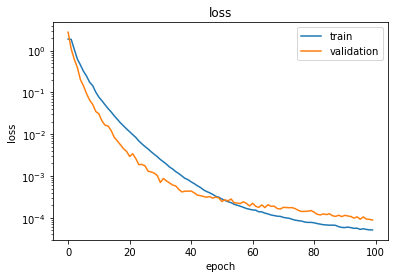

In [37]:
# Plot training curve for loss
plt.plot(train_losses[:])
plt.plot(val_losses[:])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

In [22]:
# Load test dataset
testing_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/twenty_test_data.npz', allow_pickle=True)
test_data = testing_data['arr_0'] 

# Reorganises the array into input and label arrays, same as for training and validation sets
test_X = []
test_Y = []

for i in range (len(test_data)):
  test_X.append(test_data[i][0])
  test_Y.append(test_data[i][1])

test_X = np.array(test_X)
test_Y = np.array(test_Y)

# Adds axis to create correct array shape
test_X = test_X[:, :, :, np.newaxis]

print(test_X.shape, test_Y.shape)

test_X = np.reshape(test_X, (-1,1,23,23,5))
print(test_X.shape)


(720, 23, 115, 1) (720, 11, 1)
(720, 1, 23, 23, 5)


In [23]:
# PyTorch uses tensors
x_test, y_test = map(torch.tensor, (test_X, test_Y))

# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
x_test, y_test = x_test.to(dev), y_test.to(dev)


print(x_test.shape)

x_test, y_test = preprocess(x_test, y_test)
print(x_test.shape)

torch.Size([720, 1, 23, 23, 5])
torch.Size([720, 1, 5, 23, 23])


In [24]:
print("Generate predictions using the testing dataset")
predictions = model(x_test)

print(predictions.shape)

y_test = np.squeeze(y_test)

test_error = nrmse_loss(predictions, y_test).item()

print('Test RMSE: {}'.format(test_error))

Generate predictions using the testing dataset
torch.Size([720, 11])
Test RMSE: 0.014640974812209606


In [25]:
predictions = predictions.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()

Predicted 50 labels:


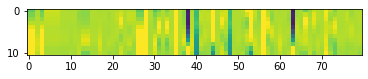

Real 50 labels:


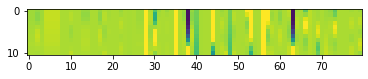

In [26]:
print("Predicted 50 labels:")
a = predictions[:80, :]
a = np.rot90(a)
plt.imshow(a, vmin=-0.26, vmax=-0.12) # The vmin vmax range was chosen to give images with visible patterns (e.g. not completely blank, thus hiding features)
plt.show()

print("Real 50 labels:")
y_test = np.squeeze(y_test)
b = y_test[:80, :]
b = np.rot90(b)
plt.imshow(b, vmin=-0.26, vmax=-0.12)
plt.show()

In [27]:
# Loads the entire dataset of both blank and wave inputs/labels
norm_inputs = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/norm_inputs.npz', allow_pickle=True)
norm_labels = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/norm_labels.npz', allow_pickle=True)

norm_inputs = norm_inputs['arr_0']
print(norm_inputs.shape)

norm_labels = norm_labels['arr_0']
print(norm_labels.shape)

#Append the normalised input images for 1 complete image to a new array
one_img = []
one_lab = []
#top row: 100% blank purple images
for i in range (50, 18550, 53): # range reflects how data was organised in 'DatasetCreator_Cosima' notebook
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

#right column: 100% blank purple images
for i in range (18550+50, 43990, 53):
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

#left column: coloured wave images
for i in range (43990+50, 69430, 53):
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

#bottom row: 100% blank purple images
for i in range (69430+50, 87980, 53):
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

one_img = np.array(one_img) # one_img has 1 entire 350x480 image data in it
one_lab = np.array(one_lab)

one_img = one_img[:, :, :, newaxis]
print(one_img.shape, one_lab.shape) 

one_img = np.reshape(one_img, (-1,1,23,23,5))
print(one_img.shape)


(87980, 23, 115)
(87980, 11, 1)
(350, 23, 115) (350, 11, 1)
(830, 23, 115) (830, 11, 1)
(1310, 23, 115) (1310, 11, 1)
(1660, 23, 115) (1660, 11, 1)


NameError: ignored

In [ ]:
# PyTorch uses tensors
one_img, one_lab = map(torch.tensor, (one_img, one_lab))

# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
one_img, one_lab = one_img.to(dev), one_lab.to(dev)

print(one_img.shape)
print(one_lab.shape)

one_img, one_lab = preprocess(one_img, one_lab)
print(one_img.shape)

In [ ]:
print("Generate predictions for 1 set of borders")
predictions2 = model(one_img)
print("predictions shape:", predictions2.shape)

one_lab = np.squeeze(one_lab)

image_error = nrmse_loss(predictions2, one_lab).item()

print('Image RMSE: {}'.format(test_error))

In [ ]:
predictions2 = predictions2.cpu().detach().numpy()
one_lab = one_lab.cpu().detach().numpy()

In [ ]:
# Top row 350 wide, showing first 50 labels to see the differences up close
print("Predicted Top Row:")
a = predictions2[0:50, :]
b = np.rot90(a)
plt.imshow(b, vmin=-0.26, vmax=-0.12)
plt.show()

print("Real Top Row:")
c = one_lab[0:50, :]
d = np.rot90(c)
plt.imshow(d, vmin=-0.26, vmax=-0.12)
plt.show()

In [ ]:
# Left column
print("Predicted Left Column:")
e = predictions2[830:1310, :]
e = np.rot90(e)
# e = np.flip(e, 1)
plt.imshow(e, vmin=-0.26, vmax=-0.12)
plt.show()

print("Real Left Column:")
g = one_lab[830:1310, :]
g = np.rot90(g)
plt.imshow(g,vmin=-0.26, vmax=-0.12)
plt.show()

In [ ]:
# Checking the differences between predicted and real images to make sure they are the same for blank and wave images
diff_blank = predictions2[0:350, :] - one_lab[0:350, :]
diff_blank = np.rot90(diff_blank)
plt.imshow(diff_blank)
plt.show()

diff_wave = predictions2[830:1310, :] - one_lab[830:1310, :]
diff_wave = np.rot90(diff_wave)
plt.imshow(diff_wave)
plt.show()

In [ ]:
# Predicted
# Get corresponding predicted parts for each border
top = predictions2[0:350, :]
top = np.rot90(top)
left = predictions2[830:1310, :]
right = predictions2[350:830, :]
bottom = predictions2[1310:1660, :]
bottom = np.rot90(bottom)

# Check their shapes
print('Predicted: top:', top.shape, 'left:', left.shape, 'right:', right.shape, 'bottom:', bottom.shape)

# Create empty array of desired rectangle size
image_out = np.zeros((502, 350))

# Save each border into the rectangle
image_out[0:11, 0:350] = top
image_out[11:491, 339:350] = right
image_out[491:502, 0:350] = bottom
image_out[11:491, 0:11] = left

# Real
# Get corresponding real parts for each border
top = one_lab[0:350, :]
top = np.rot90(top)
left = one_lab[830:1310, :]
right = one_lab[350:830, :]
bottom = one_lab[1310:1660, :]
bottom = np.rot90(bottom)

# Check their shapes
print('Real: top:', top.shape, 'left:', left.shape, 'right:', right.shape, 'bottom:', bottom.shape)

# Create empty array of desired rectangle size
image_out = np.zeros((502, 350))

# Save each border into the rectangle
image_out[0:11, 0:350] = top
image_out[11:491, 339:350] = right
image_out[491:502, 0:350] = bottom
image_out[11:491, 0:11] = left

In [ ]:
# Plot images
print('Predicted:')
plt.imshow(image_out, vmin=-0.26, vmax=-0.12)
plt.show()

print('Real:')
plt.imshow(image_out, vmin=-0.26, vmax=-0.12)
plt.show()